# Section I: Preparation

# 1. Imports & Constants

In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from IPython.display import display, Markdown

In [2]:
# Constants
CLASSIFICATION_METRICS = ['accuracy', 'precision', 'recall', 'f1']

In [3]:
# constants
CLASSIFICATION_METRIC_TO_CONSIDER = 'accuracy'

In [4]:
DATASETS_TO_SKIP = []  # put any datasets to skip here

In [5]:
MODEL_TO_DISPLAY_NAME_MAP = {
    'lstm-auto-encoder - encoder': 'LSTM-AE',
    'ts2vec - ts2vec': 'TS2Vec',
    'mcl - mcl': 'MCL',
    'timenet - timenet': 'TimeNet',
    'tsrc-mcl-lstmae - student-model-encoder': 'LSTM-AE w/ TSRC (MCL)',
    'tsrc-ts2vec-lstmae - student-model-encoder': 'LSTM-AE w/ TSRC (TS2Vec)',
    'tsrc-ts2vec-timenet - student-model-encoder': 'TimeNet w/ TSRC (TS2Vec)',
}

In [6]:
EXPERIMENTS_MAIN_OUTPUTS_DIR = Path('../experiments_outputs/')
CLASSIFICATION_MAIN_RESULTS_DIR = EXPERIMENTS_MAIN_OUTPUTS_DIR / 'classification'

In [7]:
# Make a directory for storing the plots
PLOTS_OUTPUT_DIR = Path('./analysis_output_cls')
PLOTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 2. Functions

## 2.1. Plotting Functions

In [8]:
# This function is taken from Orange3 v.3.29.3 source code under GNU [GPL-3.0] license

def compute_CD(avranks, num_datasets, alpha="0.05", test="nemenyi"):
    """
    Computes the Critical Difference for Nemenyi test.
    """
    k = len(avranks)
    print(f"Number of datasets: {num_datasets}")
    print(f"Number of algorithms: {k}")
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * num_datasets)) ** 0.5
    return cd

In [9]:
# This function is taken from Orange3 v.3.29.3 source code under GNU [GPL-3.0] license

def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]

            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

## 2.2. Statistical Tests Functions

In [10]:
def perform_cd_analysis_multiple(means, algorithm_names, alpha="0.05"):
    """
    Perform Critical Difference Analysis with multiple runs.
    means is a 3D array: datasets x runs x algorithms
    """
    # Flatten runs and datasets into one dimension while keeping algorithms separate
    reshaped_means = means.reshape(-1, means.shape[2]).T
    ranks = np.array([stats.rankdata(-m) for m in reshaped_means.T])
    avg_ranks = np.mean(ranks, axis=0)
    stat, p_value = stats.friedmanchisquare(*reshaped_means)

    print(f"Statistics={stat}, p={p_value}")

    if p_value < 0.05:
        print("Significant differences found. Proceeding to CD analysis.")
        cd = compute_CD(avg_ranks, reshaped_means.shape[1], alpha)
        print(f"Critical difference: {cd}")
        # Print ranking of each algorithm
        sorted_indexes = np.argsort(avg_ranks)
        print("\nAlgorithm Name                 Rank")
        print("-------------------------------------")
        for i in sorted_indexes:
            print(f"{algorithm_names[i]:30s} {avg_ranks[i]:.2f}")
        graph_ranks(avranks=avg_ranks, names=algorithm_names, cd=cd, reverse=True, filename=None)
    else:
        print("No significant differences found.")


In [11]:
def do_cd_analysis_multiple(results_table, algorithms_names, algorithms_display_name):
    """
    Perform Critical Difference Analysis with multiple runs data.
    
    Arguments:
    results_table: DataFrame where each cell contains a list of performance data.
    algorithms_names: List of column names in results_table that correspond to different algorithms.
    algorithms_display_name: List of names for displaying the results.
    """
    # Gather all dataset names (index of the DataFrame)
    datasets = results_table.index.tolist()

    # Determine the number of runs (assuming uniform across all cells)
    number_of_runs = len(results_table.iloc[0, 0])

    # Preparing the 3D array: datasets x runs x algorithms
    data = np.empty((len(datasets), number_of_runs, len(algorithms_names)))

    for i, algorithm in enumerate(algorithms_names):
        for j, dataset in enumerate(datasets):
            try:
                data[j, :, i] = results_table.at[dataset, algorithm]
            except ValueError as e:
                print(f"Error for dataset {dataset} and algorithm {algorithm}: {e}")

    # Pass the prepared data to the analysis function
    perform_cd_analysis_multiple(data, algorithms_display_name)


## 2.3. Utils Functions

In [12]:
def save_df_as_latex(df, filename, output_dir_path: Path = PLOTS_OUTPUT_DIR):
    """
    Save a DataFrame as a LaTeX table in a file.
    """
    df_copy = df.fillna('')  # Fill NaN values with empty strings

    full_file_path = output_dir_path / f'{filename}.tex'
    with open(full_file_path, 'w') as f:
        f.write(df_copy.style.to_latex(hrules=True, multicol_align='c', multirow_align='c'))

## 2.4. Data Processing Functions

In [13]:
def process_df_representations_results(df_results, datasets_to_skip):
    df_filtered = df_results[~df_results['dataset_name'].isin(datasets_to_skip)].copy()
    df_filtered['model_encoder_pair'] = df_filtered['model_name'] + " - " + df_filtered['encoder_name']
    return df_filtered

In [14]:
def compute_metrics_across_runs_representations(list_df_data,
                                                encoders_list,
                                                metrics,
                                                aggregate=True,
                                                values_format="mean"):
    encoder_metric_tables = {encoder: {} for encoder in encoders_list}
    metric_encoder_tables = {metric: {} for metric in metrics}

    # Table 1: One table per encoder
    for encoder in encoders_list:
        dataset_metric_values = {}

        for metric in metrics:
            for df_data in list_df_data:
                for dataset in df_data['dataset_name'].unique():
                    if dataset not in dataset_metric_values:
                        dataset_metric_values[dataset] = {m: [] for m in metrics}

            for df_data in list_df_data:
                df_filtered_data = df_data[df_data['model_encoder_pair'] == encoder]
                for dataset in df_filtered_data['dataset_name'].unique():
                    values = df_filtered_data[df_filtered_data['dataset_name'] == dataset][metric].tolist()
                    dataset_metric_values[dataset][metric].extend(values)

        if aggregate:
            for dataset, metrics_values in dataset_metric_values.items():
                for m, values in metrics_values.items():
                    mean = np.mean(values)
                    std = np.std(values)
                    dataset_metric_values[dataset][
                        m] = f"{mean:.2f} ± {std:.2f}" if values_format == 'mean_std' else mean

        result_table = pd.DataFrame.from_dict(dataset_metric_values, orient='index')
        encoder_metric_tables[encoder] = result_table

    # Table 2: One table per metric
    for metric in metrics:
        encoder_values = {}

        for encoder in encoders_list:
            for df_data in list_df_data:
                for dataset in df_data['dataset_name'].unique():
                    if dataset not in encoder_values:
                        encoder_values[dataset] = {e: [] for e in encoders_list}

            for df_data in list_df_data:
                df_filtered_data = df_data[df_data['model_encoder_pair'] == encoder]
                for dataset in df_filtered_data['dataset_name'].unique():
                    values = df_filtered_data[df_filtered_data['dataset_name'] == dataset][metric].tolist()
                    encoder_values[dataset][encoder].extend(values)

        if aggregate:
            for dataset, encoders_values in encoder_values.items():
                for e, values in encoders_values.items():
                    mean = np.mean(values)
                    std = np.std(values)
                    encoder_values[dataset][e] = f"{mean:.2f} ± {std:.2f}" if values_format == 'mean_std' else mean

        result_table = pd.DataFrame.from_dict(encoder_values, orient='index')
        metric_encoder_tables[metric] = result_table

    return encoder_metric_tables, metric_encoder_tables


In [15]:
def process_and_prepare_representations_data(data_folder_path: Path,
                                             datasets_to_skip: list,
                                             encoders_list: list,
                                             metrics: list,
                                             aggregate: bool = True,
                                             values_format: str = 'mean'):
    csv_files = [file for file in data_folder_path.iterdir() if file.suffix == '.csv']

    results_files_dataframes = [pd.read_csv(file) for file in csv_files]

    results_files_dataframes = [process_df_representations_results(df, datasets_to_skip) for df in
                                results_files_dataframes]

    encoder_metric_tables, metric_encoder_tables = compute_metrics_across_runs_representations(
        list_df_data=results_files_dataframes,
        encoders_list=encoders_list,
        metrics=metrics,
        aggregate=aggregate,
        values_format=values_format)

    return encoder_metric_tables, metric_encoder_tables

In [16]:
def analyze_representation_results(representations_results_folder: Path,
                                   metrics: list,
                                   encoders_list: list, ):
    encoder_metric_tables_display, metric_encoder_tables_display = process_and_prepare_representations_data(
        data_folder_path=representations_results_folder,
        datasets_to_skip=DATASETS_TO_SKIP,
        encoders_list=encoders_list,
        metrics=metrics,
        values_format='mean_std')

    for metric in metrics:
        display(Markdown(f'### {metric.upper()} ###'))
        display(metric_encoder_tables_display[metric].sort_index())

    encoder_metric_tables, metric_encoder_tables = process_and_prepare_representations_data(
        data_folder_path=representations_results_folder,
        datasets_to_skip=DATASETS_TO_SKIP,
        encoders_list=encoders_list,
        metrics=metrics,
        values_format='mean')

    return encoder_metric_tables, metric_encoder_tables, encoder_metric_tables_display, metric_encoder_tables_display

In [17]:
def analyze_representation_results_2(representations_results_folder: Path,
                                     metrics: list,
                                     encoders_list: list, ):
    encoder_metric_tables_mul, metric_encoder_tables_mul = process_and_prepare_representations_data(
        data_folder_path=representations_results_folder,
        datasets_to_skip=DATASETS_TO_SKIP,
        encoders_list=encoders_list,
        metrics=metrics,
        aggregate=False,
        values_format='mean_std')

    return encoder_metric_tables_mul, metric_encoder_tables_mul

### 2.5. Summarising

In [18]:
def summarize_baselines_results(baselines_tables: dict,
                                classification_metric_to_consider: str = CLASSIFICATION_METRIC_TO_CONSIDER):
    df_summarized_baselines_results = pd.DataFrame()
    for baseline_name, baseline_table in baselines_tables.items():
        metric_table = baseline_table[classification_metric_to_consider]
        df_summarized_baselines_results = pd.concat(
            [df_summarized_baselines_results, metric_table],
            axis=1)

    return df_summarized_baselines_results

# Section II: Analysis

# 3. Baselines

In [19]:
BASELINES_MAIN_DIR = CLASSIFICATION_MAIN_RESULTS_DIR / 'baselines'

## 3.1. LSTM Autoencoder (LSTM-AE)

In [20]:
lstm_ae_encoders_list = ['lstm-auto-encoder - encoder']
lstm_ae_main_dir = BASELINES_MAIN_DIR / 'ae'
lstm_ae_results_dir = lstm_ae_main_dir / 'compression_2'

In [21]:
lstm_ae_comp_2_encoder_metric_tables, lstm_ae_comp_2_metric_encoder_tables, lstm_ae_comp_2_encoder_metric_tables_display, lstm_ae_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=lstm_ae_results_dir,
                                   metrics=CLASSIFICATION_METRICS,
                                   encoders_list=lstm_ae_encoders_list)

### ACCURACY ###

,lstm-auto-encoder - encoder
ACSF1,0.62 ± 0.04
Adiac,0.54 ± 0.06
ArrowHead,0.54 ± 0.04
BME,0.75 ± 0.04
Beef,0.28 ± 0.05
...,...
Wine,0.59 ± 0.09
WordSynonyms,0.36 ± 0.01
Worms,0.43 ± 0.01
WormsTwoClass,0.50 ± 0.01


### PRECISION ###

,lstm-auto-encoder - encoder
ACSF1,0.66 ± 0.06
Adiac,0.55 ± 0.05
ArrowHead,0.54 ± 0.06
BME,0.83 ± 0.02
Beef,0.36 ± 0.08
...,...
Wine,0.59 ± 0.09
WordSynonyms,0.16 ± 0.03
Worms,0.31 ± 0.12
WormsTwoClass,0.49 ± 0.01


### RECALL ###

,lstm-auto-encoder - encoder
ACSF1,0.62 ± 0.04
Adiac,0.54 ± 0.06
ArrowHead,0.53 ± 0.05
BME,0.75 ± 0.04
Beef,0.28 ± 0.05
...,...
Wine,0.58 ± 0.09
WordSynonyms,0.16 ± 0.02
Worms,0.39 ± 0.13
WormsTwoClass,0.49 ± 0.01


### F1 ###

,lstm-auto-encoder - encoder
ACSF1,0.59 ± 0.04
Adiac,0.52 ± 0.06
ArrowHead,0.50 ± 0.07
BME,0.74 ± 0.03
Beef,0.29 ± 0.05
...,...
Wine,0.58 ± 0.09
WordSynonyms,0.15 ± 0.03
Worms,0.26 ± 0.06
WormsTwoClass,0.49 ± 0.01


In [22]:
lstm_ae_comp_2_encoder_metric_tables_mul, lstm_ae_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=lstm_ae_results_dir,
    metrics=CLASSIFICATION_METRICS,
    encoders_list=lstm_ae_encoders_list)

## 3.2. TS2Vec

In [23]:
ts2vec_encoders_list = ['ts2vec - ts2vec']
ts2vec_main_dir = BASELINES_MAIN_DIR / 'ts2vec'
ts2vec_results_dir = ts2vec_main_dir / 'compression_2'

In [24]:
ts2vec_comp_2_encoder_metric_tables, ts2vec_comp_2_metric_encoder_tables, ts2vec_comp_2_encoder_metric_tables_display, ts2vec_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=ts2vec_results_dir,
                                   metrics=CLASSIFICATION_METRICS,
                                   encoders_list=ts2vec_encoders_list)

### ACCURACY ###

,ts2vec - ts2vec
ACSF1,0.60 ± 0.01
Adiac,0.68 ± 0.02
ArrowHead,0.87 ± 0.02
BME,0.94 ± 0.01
Beef,0.39 ± 0.07
...,...
Wine,0.83 ± 0.02
WordSynonyms,0.72 ± 0.01
Worms,0.43 ± 0.00
WormsTwoClass,0.64 ± 0.02


### PRECISION ###

,ts2vec - ts2vec
ACSF1,0.67 ± 0.04
Adiac,0.70 ± 0.03
ArrowHead,0.87 ± 0.02
BME,0.95 ± 0.01
Beef,0.42 ± 0.05
...,...
Wine,0.83 ± 0.02
WordSynonyms,0.71 ± 0.03
Worms,0.16 ± 0.06
WormsTwoClass,0.64 ± 0.03


### RECALL ###

,ts2vec - ts2vec
ACSF1,0.60 ± 0.01
Adiac,0.68 ± 0.02
ArrowHead,0.87 ± 0.02
BME,0.94 ± 0.01
Beef,0.39 ± 0.07
...,...
Wine,0.83 ± 0.02
WordSynonyms,0.57 ± 0.01
Worms,0.38 ± 0.15
WormsTwoClass,0.62 ± 0.02


### F1 ###

,ts2vec - ts2vec
ACSF1,0.58 ± 0.01
Adiac,0.67 ± 0.03
ArrowHead,0.87 ± 0.02
BME,0.94 ± 0.01
Beef,0.39 ± 0.07
...,...
Wine,0.83 ± 0.02
WordSynonyms,0.61 ± 0.02
Worms,0.23 ± 0.09
WormsTwoClass,0.62 ± 0.02


In [25]:
ts2vec_comp_2_encoder_metric_tables_mul, ts2vec_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=ts2vec_results_dir,
    metrics=CLASSIFICATION_METRICS,
    encoders_list=ts2vec_encoders_list)

## 3.3. MCL

In [26]:
mcl_encoders_list = ['mcl - mcl']
mcl_main_dir = BASELINES_MAIN_DIR / 'mcl'
mcl_results_dir = mcl_main_dir / 'compression_2'

In [27]:
mcl_comp_2_encoder_metric_tables, mcl_comp_2_metric_encoder_tables, mcl_comp_2_encoder_metrics_tables_display, mcl_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=mcl_results_dir,
                                   metrics=CLASSIFICATION_METRICS,
                                   encoders_list=mcl_encoders_list)

### ACCURACY ###

,mcl - mcl
ACSF1,0.64 ± 0.05
Adiac,0.69 ± 0.02
ArrowHead,0.86 ± 0.02
BME,0.97 ± 0.02
Beef,0.54 ± 0.06
...,...
Wine,0.87 ± 0.05
WordSynonyms,0.62 ± 0.01
Worms,0.42 ± 0.02
WormsTwoClass,0.54 ± 0.03


### PRECISION ###

,mcl - mcl
ACSF1,0.68 ± 0.05
Adiac,0.70 ± 0.02
ArrowHead,0.86 ± 0.02
BME,0.97 ± 0.02
Beef,0.57 ± 0.06
...,...
Wine,0.88 ± 0.05
WordSynonyms,0.51 ± 0.02
Worms,0.24 ± 0.12
WormsTwoClass,0.46 ± 0.10


### RECALL ###

,mcl - mcl
ACSF1,0.64 ± 0.05
Adiac,0.69 ± 0.02
ArrowHead,0.86 ± 0.02
BME,0.97 ± 0.02
Beef,0.54 ± 0.06
...,...
Wine,0.87 ± 0.05
WordSynonyms,0.44 ± 0.01
Worms,0.24 ± 0.04
WormsTwoClass,0.51 ± 0.03


### F1 ###

,mcl - mcl
ACSF1,0.62 ± 0.06
Adiac,0.68 ± 0.02
ArrowHead,0.86 ± 0.02
BME,0.97 ± 0.02
Beef,0.53 ± 0.06
...,...
Wine,0.87 ± 0.05
WordSynonyms,0.46 ± 0.01
Worms,0.19 ± 0.07
WormsTwoClass,0.47 ± 0.07


In [28]:
mcl_comp_2_encoder_metric_tables_mul, mcl_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=mcl_results_dir,
    metrics=CLASSIFICATION_METRICS,
    encoders_list=mcl_encoders_list)

## 3.4. TimeNet

In [29]:
timenet_encoders_list = ['timenet - timenet']
timenet_main_dir = BASELINES_MAIN_DIR / 'timenet'
timenet_results_dir = timenet_main_dir / 'compression_2'

In [30]:
timenet_comp_2_encoder_metric_tables, timenet_comp_2_metric_encoder_tables, timenet_comp_2_encoder_metrics_tables_display, timenet_comp_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=timenet_results_dir,
                                   metrics=CLASSIFICATION_METRICS,
                                   encoders_list=timenet_encoders_list)

### ACCURACY ###

,timenet - timenet
ACSF1,0.61 ± 0.02
Adiac,0.60 ± 0.04
ArrowHead,0.59 ± 0.06
BME,0.88 ± 0.08
Beef,0.45 ± 0.03
...,...
Wine,0.80 ± 0.07
WordSynonyms,0.53 ± 0.01
Worms,0.43 ± 0.00
WormsTwoClass,0.49 ± 0.05


### PRECISION ###

,timenet - timenet
ACSF1,0.67 ± 0.04
Adiac,0.60 ± 0.03
ArrowHead,0.59 ± 0.06
BME,0.89 ± 0.08
Beef,0.50 ± 0.09
...,...
Wine,0.80 ± 0.07
WordSynonyms,0.39 ± 0.03
Worms,0.16 ± 0.06
WormsTwoClass,0.49 ± 0.05


### RECALL ###

,timenet - timenet
ACSF1,0.61 ± 0.02
Adiac,0.59 ± 0.04
ArrowHead,0.58 ± 0.07
BME,0.88 ± 0.08
Beef,0.45 ± 0.03
...,...
Wine,0.80 ± 0.07
WordSynonyms,0.33 ± 0.02
Worms,0.38 ± 0.15
WormsTwoClass,0.49 ± 0.05


### F1 ###

,timenet - timenet
ACSF1,0.58 ± 0.03
Adiac,0.59 ± 0.03
ArrowHead,0.58 ± 0.07
BME,0.88 ± 0.08
Beef,0.42 ± 0.04
...,...
Wine,0.80 ± 0.07
WordSynonyms,0.34 ± 0.02
Worms,0.23 ± 0.09
WormsTwoClass,0.49 ± 0.05


In [31]:
timenet_comp_2_encoder_metric_tables_mul, timenet_comp_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=timenet_results_dir,
    metrics=CLASSIFICATION_METRICS,
    encoders_list=timenet_encoders_list)

## 3.5. Baselines Summary

In [32]:
baselines_tables_display = {
    'lstm_ae': lstm_ae_comp_2_metric_encoder_tables_display,
    'ts2vec': ts2vec_comp_2_metric_encoder_tables_display,
    'mcl': mcl_comp_2_metric_encoder_tables_display,
    'timenet': timenet_comp_2_metric_encoder_tables_display
}

In [33]:
baselines_tables = {
    'lstm_ae': lstm_ae_comp_2_metric_encoder_tables,
    'ts2vec': ts2vec_comp_2_metric_encoder_tables,
    'mcl': mcl_comp_2_metric_encoder_tables,
    'timenet': timenet_comp_2_metric_encoder_tables,
}

In [34]:
baselines_tables_mul = {
    'lstm_ae': lstm_ae_comp_2_metric_encoder_tables_mul,
    'ts2vec': ts2vec_comp_2_metric_encoder_tables_mul,
    'mcl': mcl_comp_2_metric_encoder_tables_mul,
    'timenet': timenet_comp_2_metric_encoder_tables_mul,
}

In [35]:
df_summarized_baselines_results_display \
    = summarize_baselines_results(baselines_tables=baselines_tables_display,
                                  classification_metric_to_consider=CLASSIFICATION_METRIC_TO_CONSIDER)


In [36]:
df_summarized_baselines_results_display

,lstm-auto-encoder - encoder,ts2vec - ts2vec,mcl - mcl,timenet - timenet
ACSF1,0.62 ± 0.04,0.60 ± 0.01,0.64 ± 0.05,0.61 ± 0.02
Adiac,0.54 ± 0.06,0.68 ± 0.02,0.69 ± 0.02,0.60 ± 0.04
ArrowHead,0.54 ± 0.04,0.87 ± 0.02,0.86 ± 0.02,0.59 ± 0.06
BME,0.75 ± 0.04,0.94 ± 0.01,0.97 ± 0.02,0.88 ± 0.08
Beef,0.28 ± 0.05,0.39 ± 0.07,0.54 ± 0.06,0.45 ± 0.03
...,...,...,...,...
Wine,0.59 ± 0.09,0.83 ± 0.02,0.87 ± 0.05,0.80 ± 0.07
WordSynonyms,0.36 ± 0.01,0.72 ± 0.01,0.62 ± 0.01,0.53 ± 0.01
Worms,0.43 ± 0.01,0.43 ± 0.00,0.42 ± 0.02,0.43 ± 0.00
WormsTwoClass,0.50 ± 0.01,0.64 ± 0.02,0.54 ± 0.03,0.49 ± 0.05


In [37]:
df_summarized_baselines_results_mul \
    = summarize_baselines_results(baselines_tables=baselines_tables_mul,
                                  classification_metric_to_consider=CLASSIFICATION_METRIC_TO_CONSIDER)

In [38]:
df_summarized_baselines_results_mul

,lstm-auto-encoder - encoder,ts2vec - ts2vec,mcl - mcl,timenet - timenet
ACSF1,"[0.65, 0.63, 0.61, 0.64, 0.55]","[0.59, 0.61, 0.6, 0.6, 0.58]","[0.65, 0.58, 0.69, 0.69, 0.58]","[0.62, 0.62, 0.62, 0.61, 0.56]"
Adiac,"[0.4552429667519181, 0.6265984654731458, 0.498...","[0.6982097186700768, 0.6879795396419437, 0.690...","[0.7084398976982097, 0.6751918158567775, 0.728...","[0.6214833759590793, 0.6342710997442456, 0.542..."
ArrowHead,"[0.6037735849056604, 0.5188679245283019, 0.481...","[0.8679245283018868, 0.8867924528301887, 0.877...","[0.8773584905660378, 0.8773584905660378, 0.867...","[0.6792452830188679, 0.5188679245283019, 0.566..."
BME,"[0.8, 0.6888888888888889, 0.7555555555555555, ...","[0.9444444444444444, 0.9444444444444444, 0.933...","[0.9555555555555556, 0.9777777777777776, 0.988...","[0.9555555555555556, 0.7333333333333333, 0.877..."
Beef,"[0.2333333333333333, 0.3666666666666666, 0.233...","[0.5333333333333333, 0.3333333333333333, 0.366...","[0.4333333333333333, 0.6333333333333333, 0.533...","[0.4666666666666667, 0.4, 0.5, 0.4333333333333..."
...,...,...,...,...
Wine,"[0.5535714285714286, 0.5178571428571429, 0.535...","[0.8571428571428571, 0.8214285714285714, 0.821...","[0.8214285714285714, 0.9464285714285714, 0.821...","[0.8392857142857143, 0.7321428571428571, 0.803..."
WordSynonyms,"[0.3620309050772627, 0.3377483443708609, 0.377...","[0.7152317880794702, 0.7306843267108167, 0.732...","[0.6048565121412803, 0.6313465783664459, 0.620...","[0.5187637969094923, 0.5298013245033113, 0.549..."
Worms,"[0.4263565891472868, 0.4263565891472868, 0.434...","[0.4263565891472868, 0.4263565891472868, 0.426...","[0.4341085271317829, 0.4263565891472868, 0.434...","[0.4263565891472868, 0.4263565891472868, 0.426..."
WormsTwoClass,"[0.4961240310077519, 0.4961240310077519, 0.496...","[0.6356589147286822, 0.627906976744186, 0.6899...","[0.5736434108527132, 0.4883720930232558, 0.542...","[0.5193798449612403, 0.5658914728682171, 0.426..."


Statistics=460.4260165662648, p=1.7956472329166645e-99
Significant differences found. Proceeding to CD analysis.
Number of datasets: 560
Number of algorithms: 4
Critical difference: 0.19820512187990647

Algorithm Name                 Rank
-------------------------------------
TS2Vec                         1.73
MCL                            2.43
TimeNet                        2.51
LSTM-AE                        3.33


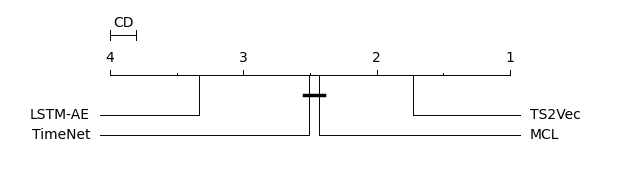

In [39]:
baselines_display_names = ['LSTM-AE', 'TS2Vec', 'MCL', 'TimeNet']
do_cd_analysis_multiple(df_summarized_baselines_results_mul,
                        df_summarized_baselines_results_mul.columns,
                        baselines_display_names)

plt.savefig(PLOTS_OUTPUT_DIR / 'baselines_cd.eps', format='eps', bbox_inches='tight', dpi=300)

# 4. TSRC

In [40]:
TSRC_MODEL_MAIN_DIR = CLASSIFICATION_MAIN_RESULTS_DIR / 'representations'

### 4.1 Experiment 1

In [41]:
experiment_1_main_dir = TSRC_MODEL_MAIN_DIR / 'ts2vec_to_timenet_88c1e7d54bda54398837d6eff0022678'

In [42]:
experiment_1_results_dir = experiment_1_main_dir / 'compression_2'

In [43]:
experiment_1_encoders_list = ['tsrc-ts2vec-timenet - student-model-encoder']

In [44]:
experiment_1_encoder_metric_tables, experiment_1_metric_encoder_tables, experiment_1_encoder_metric_tables_display, experiment_1_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=experiment_1_results_dir,
                                   metrics=CLASSIFICATION_METRICS,
                                   encoders_list=experiment_1_encoders_list)

### ACCURACY ###

,tsrc-ts2vec-timenet - student-model-encoder
ACSF1,0.62 ± 0.05
Adiac,0.66 ± 0.02
ArrowHead,0.72 ± 0.06
BME,0.96 ± 0.03
Beef,0.52 ± 0.03
...,...
Wine,0.78 ± 0.05
WordSynonyms,0.61 ± 0.02
Worms,0.48 ± 0.03
WormsTwoClass,0.52 ± 0.03


### PRECISION ###

,tsrc-ts2vec-timenet - student-model-encoder
ACSF1,0.69 ± 0.03
Adiac,0.67 ± 0.03
ArrowHead,0.73 ± 0.05
BME,0.96 ± 0.02
Beef,0.60 ± 0.05
...,...
Wine,0.78 ± 0.05
WordSynonyms,0.50 ± 0.05
Worms,0.41 ± 0.16
WormsTwoClass,0.51 ± 0.03


### RECALL ###

,tsrc-ts2vec-timenet - student-model-encoder
ACSF1,0.62 ± 0.05
Adiac,0.66 ± 0.02
ArrowHead,0.72 ± 0.06
BME,0.96 ± 0.03
Beef,0.52 ± 0.03
...,...
Wine,0.78 ± 0.05
WordSynonyms,0.45 ± 0.04
Worms,0.39 ± 0.10
WormsTwoClass,0.51 ± 0.03


### F1 ###

,tsrc-ts2vec-timenet - student-model-encoder
ACSF1,0.61 ± 0.06
Adiac,0.65 ± 0.02
ArrowHead,0.72 ± 0.06
BME,0.96 ± 0.03
Beef,0.50 ± 0.04
...,...
Wine,0.78 ± 0.05
WordSynonyms,0.45 ± 0.04
Worms,0.39 ± 0.14
WormsTwoClass,0.51 ± 0.03


In [45]:
experiment_1_encoder_metric_tables_mul, experiment_1_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=experiment_1_results_dir,
    metrics=CLASSIFICATION_METRICS,
    encoders_list=experiment_1_encoders_list)

In [46]:
experiment_1_baselines_columns = ['ts2vec - ts2vec', 'timenet - timenet']
experiment_1_baseline_results_mul = df_summarized_baselines_results_mul[experiment_1_baselines_columns]

In [47]:
experiment_1_results_mul = pd.concat([experiment_1_metric_encoder_tables_mul[CLASSIFICATION_METRIC_TO_CONSIDER],
                                      experiment_1_baseline_results_mul], axis=1)

In [48]:
experiment_1_results_mul

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
ACSF1,"[0.68, 0.68, 0.59, 0.57, 0.59]","[0.59, 0.61, 0.6, 0.6, 0.58]","[0.62, 0.62, 0.62, 0.61, 0.56]"
Adiac,"[0.6649616368286445, 0.6445012787723785, 0.644...","[0.6982097186700768, 0.6879795396419437, 0.690...","[0.6214833759590793, 0.6342710997442456, 0.542..."
ArrowHead,"[0.7264150943396226, 0.6226415094339622, 0.726...","[0.8679245283018868, 0.8867924528301887, 0.877...","[0.6792452830188679, 0.5188679245283019, 0.566..."
BME,"[0.9111111111111112, 0.9666666666666668, 0.966...","[0.9444444444444444, 0.9444444444444444, 0.933...","[0.9555555555555556, 0.7333333333333333, 0.877..."
Beef,"[0.5, 0.5333333333333333, 0.5333333333333333, ...","[0.5333333333333333, 0.3333333333333333, 0.366...","[0.4666666666666667, 0.4, 0.5, 0.4333333333333..."
...,...,...,...
Wine,"[0.7678571428571429, 0.8571428571428571, 0.803...","[0.8571428571428571, 0.8214285714285714, 0.821...","[0.8392857142857143, 0.7321428571428571, 0.803..."
WordSynonyms,"[0.6357615894039735, 0.6313465783664459, 0.618...","[0.7152317880794702, 0.7306843267108167, 0.732...","[0.5187637969094923, 0.5298013245033113, 0.549..."
Worms,"[0.4728682170542636, 0.5038759689922481, 0.426...","[0.4263565891472868, 0.4263565891472868, 0.426...","[0.4263565891472868, 0.4263565891472868, 0.426..."
WormsTwoClass,"[0.5116279069767442, 0.5193798449612403, 0.558...","[0.6356589147286822, 0.627906976744186, 0.6899...","[0.5193798449612403, 0.5658914728682171, 0.426..."


In [49]:
experiment_1_results_mul

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
ACSF1,"[0.68, 0.68, 0.59, 0.57, 0.59]","[0.59, 0.61, 0.6, 0.6, 0.58]","[0.62, 0.62, 0.62, 0.61, 0.56]"
Adiac,"[0.6649616368286445, 0.6445012787723785, 0.644...","[0.6982097186700768, 0.6879795396419437, 0.690...","[0.6214833759590793, 0.6342710997442456, 0.542..."
ArrowHead,"[0.7264150943396226, 0.6226415094339622, 0.726...","[0.8679245283018868, 0.8867924528301887, 0.877...","[0.6792452830188679, 0.5188679245283019, 0.566..."
BME,"[0.9111111111111112, 0.9666666666666668, 0.966...","[0.9444444444444444, 0.9444444444444444, 0.933...","[0.9555555555555556, 0.7333333333333333, 0.877..."
Beef,"[0.5, 0.5333333333333333, 0.5333333333333333, ...","[0.5333333333333333, 0.3333333333333333, 0.366...","[0.4666666666666667, 0.4, 0.5, 0.4333333333333..."
...,...,...,...
Wine,"[0.7678571428571429, 0.8571428571428571, 0.803...","[0.8571428571428571, 0.8214285714285714, 0.821...","[0.8392857142857143, 0.7321428571428571, 0.803..."
WordSynonyms,"[0.6357615894039735, 0.6313465783664459, 0.618...","[0.7152317880794702, 0.7306843267108167, 0.732...","[0.5187637969094923, 0.5298013245033113, 0.549..."
Worms,"[0.4728682170542636, 0.5038759689922481, 0.426...","[0.4263565891472868, 0.4263565891472868, 0.426...","[0.4263565891472868, 0.4263565891472868, 0.426..."
WormsTwoClass,"[0.5116279069767442, 0.5193798449612403, 0.558...","[0.6356589147286822, 0.627906976744186, 0.6899...","[0.5193798449612403, 0.5658914728682171, 0.426..."


In [50]:
experiment_1_baselines_results_display = df_summarized_baselines_results_display[
    experiment_1_baselines_columns]
experiment_1_results_display = pd.concat(
    [experiment_1_metric_encoder_tables_display[CLASSIFICATION_METRIC_TO_CONSIDER],
     experiment_1_baselines_results_display], axis=1)

In [51]:
experiment_1_results_display

,tsrc-ts2vec-timenet - student-model-encoder,ts2vec - ts2vec,timenet - timenet
ACSF1,0.62 ± 0.05,0.60 ± 0.01,0.61 ± 0.02
Adiac,0.66 ± 0.02,0.68 ± 0.02,0.60 ± 0.04
ArrowHead,0.72 ± 0.06,0.87 ± 0.02,0.59 ± 0.06
BME,0.96 ± 0.03,0.94 ± 0.01,0.88 ± 0.08
Beef,0.52 ± 0.03,0.39 ± 0.07,0.45 ± 0.03
...,...,...,...
Wine,0.78 ± 0.05,0.83 ± 0.02,0.80 ± 0.07
WordSynonyms,0.61 ± 0.02,0.72 ± 0.01,0.53 ± 0.01
Worms,0.48 ± 0.03,0.43 ± 0.00,0.43 ± 0.00
WormsTwoClass,0.52 ± 0.03,0.64 ± 0.02,0.49 ± 0.05


### 4.2 Experiment 2

In [52]:
experiment_2_main_dir = TSRC_MODEL_MAIN_DIR / 'ts2vec_to_lstmae_aecc4ffa8c36aa6d9bccaf9d83dac024'

In [53]:
experiment_2_results_dir = experiment_2_main_dir / 'compression_2'

In [54]:
experiment_2_encoders_list = ['tsrc-ts2vec-lstmae - student-model-encoder']

In [55]:
experiment_2_encoder_metric_tables, experiment_2_metric_encoder_tables, experiment_2_encoder_metric_tables_display, experiment_2_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=experiment_2_results_dir,
                                   metrics=CLASSIFICATION_METRICS,
                                   encoders_list=experiment_2_encoders_list)

### ACCURACY ###

,tsrc-ts2vec-lstmae - student-model-encoder
ACSF1,0.63 ± 0.03
Adiac,0.57 ± 0.02
ArrowHead,0.65 ± 0.06
BME,0.83 ± 0.05
Beef,0.31 ± 0.08
...,...
Wine,0.73 ± 0.11
WordSynonyms,0.51 ± 0.04
Worms,0.43 ± 0.01
WormsTwoClass,0.54 ± 0.03


### PRECISION ###

,tsrc-ts2vec-lstmae - student-model-encoder
ACSF1,0.65 ± 0.03
Adiac,0.58 ± 0.02
ArrowHead,0.68 ± 0.05
BME,0.83 ± 0.05
Beef,0.38 ± 0.10
...,...
Wine,0.73 ± 0.11
WordSynonyms,0.37 ± 0.05
Worms,0.24 ± 0.16
WormsTwoClass,0.48 ± 0.10


### RECALL ###

,tsrc-ts2vec-lstmae - student-model-encoder
ACSF1,0.63 ± 0.03
Adiac,0.57 ± 0.02
ArrowHead,0.65 ± 0.06
BME,0.83 ± 0.05
Beef,0.31 ± 0.08
...,...
Wine,0.73 ± 0.11
WordSynonyms,0.32 ± 0.04
Worms,0.30 ± 0.11
WormsTwoClass,0.52 ± 0.02


### F1 ###

,tsrc-ts2vec-lstmae - student-model-encoder
ACSF1,0.62 ± 0.04
Adiac,0.56 ± 0.02
ArrowHead,0.65 ± 0.06
BME,0.83 ± 0.05
Beef,0.32 ± 0.08
...,...
Wine,0.73 ± 0.11
WordSynonyms,0.33 ± 0.04
Worms,0.23 ± 0.09
WormsTwoClass,0.49 ± 0.07


In [56]:
experiment_2_encoder_metric_tables_mul, experiment_2_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=experiment_2_results_dir,
    metrics=CLASSIFICATION_METRICS,
    encoders_list=experiment_2_encoders_list)

In [57]:
experiment_2_baselines_columns = ['ts2vec - ts2vec', 'lstm-auto-encoder - encoder']
experiment_2_baselines_results_mul = df_summarized_baselines_results_mul[experiment_2_baselines_columns]

In [58]:
experiment_2_results_mul = pd.concat([experiment_2_metric_encoder_tables_mul[CLASSIFICATION_METRIC_TO_CONSIDER],
                                      experiment_2_baselines_results_mul], axis=1)

In [59]:
experiment_2_baselines_results_display = df_summarized_baselines_results_display[
    experiment_2_baselines_columns]
experiment_2_results_display = pd.concat(
    [experiment_2_metric_encoder_tables_display[CLASSIFICATION_METRIC_TO_CONSIDER],
     experiment_2_baselines_results_display], axis=1)

In [60]:
experiment_2_results_display

,tsrc-ts2vec-lstmae - student-model-encoder,ts2vec - ts2vec,lstm-auto-encoder - encoder
ACSF1,0.63 ± 0.03,0.60 ± 0.01,0.62 ± 0.04
Adiac,0.57 ± 0.02,0.68 ± 0.02,0.54 ± 0.06
ArrowHead,0.65 ± 0.06,0.87 ± 0.02,0.54 ± 0.04
BME,0.83 ± 0.05,0.94 ± 0.01,0.75 ± 0.04
Beef,0.31 ± 0.08,0.39 ± 0.07,0.28 ± 0.05
...,...,...,...
Wine,0.73 ± 0.11,0.83 ± 0.02,0.59 ± 0.09
WordSynonyms,0.51 ± 0.04,0.72 ± 0.01,0.36 ± 0.01
Worms,0.43 ± 0.01,0.43 ± 0.00,0.43 ± 0.01
WormsTwoClass,0.54 ± 0.03,0.64 ± 0.02,0.50 ± 0.01


### 4.3 Experiment 3

In [61]:
experiment_3_main_dir = TSRC_MODEL_MAIN_DIR / 'mcl_to_lstmae_841548f56ad1cc5fd09a9f2e2086e6df'

In [62]:
experiment_3_results_dir = experiment_3_main_dir / 'compression_2'

In [63]:
experiment_3_encoders_list = ['tsrc-mcl-lstmae - student-model-encoder']

In [64]:
experiment_3_encoder_metric_tables, experiment_3_metric_encoder_tables, experiment_3_encoder_metric_tables_display, experiment_3_metric_encoder_tables_display = \
    analyze_representation_results(representations_results_folder=experiment_3_results_dir,
                                   metrics=CLASSIFICATION_METRICS,
                                   encoders_list=experiment_3_encoders_list)

### ACCURACY ###

,tsrc-mcl-lstmae - student-model-encoder
ACSF1,0.59 ± 0.04
Adiac,0.51 ± 0.06
ArrowHead,0.66 ± 0.08
BME,0.79 ± 0.05
Beef,0.39 ± 0.08
...,...
Wine,0.64 ± 0.06
WordSynonyms,0.41 ± 0.04
Worms,0.44 ± 0.04
WormsTwoClass,0.52 ± 0.02


### PRECISION ###

,tsrc-mcl-lstmae - student-model-encoder
ACSF1,0.60 ± 0.07
Adiac,0.51 ± 0.07
ArrowHead,0.66 ± 0.08
BME,0.82 ± 0.06
Beef,0.46 ± 0.12
...,...
Wine,0.65 ± 0.07
WordSynonyms,0.17 ± 0.06
Worms,0.27 ± 0.11
WormsTwoClass,0.50 ± 0.02


### RECALL ###

,tsrc-mcl-lstmae - student-model-encoder
ACSF1,0.59 ± 0.04
Adiac,0.50 ± 0.07
ArrowHead,0.66 ± 0.09
BME,0.79 ± 0.05
Beef,0.39 ± 0.08
...,...
Wine,0.64 ± 0.06
WordSynonyms,0.17 ± 0.04
Worms,0.50 ± 0.01
WormsTwoClass,0.50 ± 0.02


### F1 ###

,tsrc-mcl-lstmae - student-model-encoder
ACSF1,0.58 ± 0.05
Adiac,0.49 ± 0.07
ArrowHead,0.65 ± 0.08
BME,0.78 ± 0.05
Beef,0.39 ± 0.08
...,...
Wine,0.63 ± 0.06
WordSynonyms,0.15 ± 0.05
Worms,0.33 ± 0.07
WormsTwoClass,0.50 ± 0.02


In [65]:
experiment_3_encoder_metric_tables_mul, experiment_3_metric_encoder_tables_mul = analyze_representation_results_2(
    representations_results_folder=experiment_3_results_dir,
    metrics=CLASSIFICATION_METRICS,
    encoders_list=experiment_3_encoders_list)

In [66]:
experiment_3_baselines_columns = ['mcl - mcl', 'lstm-auto-encoder - encoder']

In [67]:
experiment_3_baselines_results_mul = df_summarized_baselines_results_mul[experiment_3_baselines_columns]

In [68]:
experiment_3_results_mul = pd.concat([experiment_3_metric_encoder_tables_mul[CLASSIFICATION_METRIC_TO_CONSIDER],
                                      experiment_3_baselines_results_mul], axis=1)

In [69]:
experiment_3_baselines_results_display = df_summarized_baselines_results_display[
    experiment_3_baselines_columns]
experiment_3_results_display = pd.concat(
    [experiment_3_metric_encoder_tables_display[CLASSIFICATION_METRIC_TO_CONSIDER],
     experiment_3_baselines_results_display], axis=1)

## 4.4. All Experiments

In [70]:
all_experiments_results_mul = pd.concat([experiment_1_results_mul, experiment_2_results_mul, experiment_3_results_mul,
                                         df_summarized_baselines_results_mul], axis=1)
all_experiments_results_mul = all_experiments_results_mul.loc[:, ~all_experiments_results_mul.columns.duplicated()]

In [71]:
all_experiment_results_display = pd.concat(
    [experiment_1_results_display, experiment_2_results_display, experiment_3_results_display], axis=1)
all_experiment_results_display = all_experiment_results_display.loc[:,
                                 ~all_experiment_results_display.columns.duplicated()]
# rename the columns to be more descriptive (use the mapping)
all_experiment_results_display.columns = [MODEL_TO_DISPLAY_NAME_MAP[col] for col in
                                          all_experiment_results_display.columns]
# order the columns and put the baselines first
all_experiment_results_display = all_experiment_results_display[
    baselines_display_names + all_experiment_results_display.columns.difference(baselines_display_names).tolist()]

In [72]:
all_experiment_results_display

,LSTM-AE,TS2Vec,MCL,TimeNet,LSTM-AE w/ TSRC (MCL),LSTM-AE w/ TSRC (TS2Vec),TimeNet w/ TSRC (TS2Vec)
ACSF1,0.62 ± 0.04,0.60 ± 0.01,0.64 ± 0.05,0.61 ± 0.02,0.59 ± 0.04,0.63 ± 0.03,0.62 ± 0.05
Adiac,0.54 ± 0.06,0.68 ± 0.02,0.69 ± 0.02,0.60 ± 0.04,0.51 ± 0.06,0.57 ± 0.02,0.66 ± 0.02
ArrowHead,0.54 ± 0.04,0.87 ± 0.02,0.86 ± 0.02,0.59 ± 0.06,0.66 ± 0.08,0.65 ± 0.06,0.72 ± 0.06
BME,0.75 ± 0.04,0.94 ± 0.01,0.97 ± 0.02,0.88 ± 0.08,0.79 ± 0.05,0.83 ± 0.05,0.96 ± 0.03
Beef,0.28 ± 0.05,0.39 ± 0.07,0.54 ± 0.06,0.45 ± 0.03,0.39 ± 0.08,0.31 ± 0.08,0.52 ± 0.03
...,...,...,...,...,...,...,...
Wine,0.59 ± 0.09,0.83 ± 0.02,0.87 ± 0.05,0.80 ± 0.07,0.64 ± 0.06,0.73 ± 0.11,0.78 ± 0.05
WordSynonyms,0.36 ± 0.01,0.72 ± 0.01,0.62 ± 0.01,0.53 ± 0.01,0.41 ± 0.04,0.51 ± 0.04,0.61 ± 0.02
Worms,0.43 ± 0.01,0.43 ± 0.00,0.42 ± 0.02,0.43 ± 0.00,0.44 ± 0.04,0.43 ± 0.01,0.48 ± 0.03
WormsTwoClass,0.50 ± 0.01,0.64 ± 0.02,0.54 ± 0.03,0.49 ± 0.05,0.52 ± 0.02,0.54 ± 0.03,0.52 ± 0.03


In [73]:
# save as latex
save_df_as_latex(all_experiment_results_display, 'all_experiments_results')

Statistics=1042.578878485854, p=5.51654477698352e-222
Significant differences found. Proceeding to CD analysis.
Number of datasets: 560
Number of algorithms: 7
Critical difference: 0.38062647530967497

Algorithm Name                 Rank
-------------------------------------
TS2Vec                         2.34
TimeNet w/ TSRC (TS2Vec)       3.04
MCL                            3.50
TimeNet                        3.71
LSTM-AE w/ TSRC (TS2Vec)       4.69
LSTM-AE                        5.21
LSTM-AE w/ TSRC (MCL)          5.52


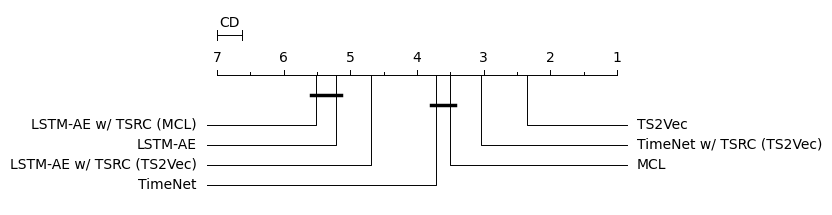

In [74]:
all_experiments_display_names = [MODEL_TO_DISPLAY_NAME_MAP[col] for col in all_experiments_results_mul.columns]

do_cd_analysis_multiple(all_experiments_results_mul, all_experiments_results_mul.columns, all_experiments_display_names)

# save the figure as eps
plt.savefig(PLOTS_OUTPUT_DIR / 'all_experiments_cd.eps', format='eps', bbox_inches='tight', dpi=300)

# save the figure as png
plt.savefig(PLOTS_OUTPUT_DIR / 'all_experiments_cd.png', format='png', bbox_inches='tight', dpi=300)

In [75]:
# Calculating improvements:

ranks_original = {
    "TS2Vec": 2.34,
    "TimeNet_w_TSRC_TS2Vec": 3.04,
    "MCL": 3.50,
    "TimeNet": 3.71,
    "LSTM_AE_w_TSRC_TS2Vec": 4.69,
    "LSTM_AE": 5.21,
    "LSTM_AE_w_TSRC_MCL": 5.25
}
improvements = {
    "TimeNet_w_TSRC_TS2Vec": ((ranks_original["TimeNet"] - ranks_original["TimeNet_w_TSRC_TS2Vec"]) / ranks_original[
        "TimeNet"]) * 100,
    "LSTM_AE_w_TSRC_TS2Vec": ((ranks_original["LSTM_AE"] - ranks_original["LSTM_AE_w_TSRC_TS2Vec"]) / ranks_original[
        "LSTM_AE"]) * 100,
    "LSTM_AE_w_TSRC_MCL": ((ranks_original["LSTM_AE"] - ranks_original["LSTM_AE_w_TSRC_MCL"]) / ranks_original[
        "LSTM_AE"]) * 100,
}

# Calculate the mean of the improvements:
mean_improvement = sum(improvements.values()) / len(improvements)
improvements, mean_improvement

({'TimeNet_w_TSRC_TS2Vec': 18.059299191374663,
  'LSTM_AE_w_TSRC_TS2Vec': 9.980806142034542,
  'LSTM_AE_w_TSRC_MCL': -0.7677543186180429},
 9.090783671597054)